In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob

In [15]:
ds = xr.open_dataset("/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-01-01-00000.nc")
ds

<xarray.Dataset>
Dimensions:       (lat: 96, lon: 144, mlat: 97, mlon: 80, lev: 126, ilev: 127,
                   time: 24, nbnd: 2)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lon           (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * mlat          (mlat) float64 -90.0 -88.12 -86.24 -84.33 ... 86.24 88.12 90.0
  * mlon          (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * lev           (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev          (ilev) float64 3.551e-10 4.559e-10 5.854e-10 ... 985.1 1e+03
  * time          (time) object 2100-01-01 00:00:00 ... 2100-01-01 23:00:00
Dimensions without coordinates: nbnd
Data variables: (12/113)
    gw            (lat) float64 ...
    hyam          (lev) float64 ...
    hybm          (lev) float64 ...
    P0            float64 ...
    hyai          (ilev) float64 ...
    hybi          (ilev) float64 ...
    ...            ...
    UI            (time, lev, lat, lon) float32 ...
    V             (time, lev, lat, lon) float32 ...
    VI            (time, lev, lat, lon) float32 ...
    WI            (time, lev, lat, lon) float32 ...
    Z3            (time, lev, lat, lon) float32 ...
    e             (time, lev, lat, lon) float32 ...
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              FX2100f19f19mg16NaFeMgiontransport
    logname:           earfw
    host:              d8s5b4.arc4.leed
    initial_file:      /resstore/b0154/Data/earfw/MCHEM24/Joe_WACCMX_2_WF_lev...
    topography_file:   /nobackup/earfw/cesm2_inputdata//atm/cam/topo/USGS-gto...
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    time_period_freq:  hour_1

In [11]:
def plot_height_profile_ion_densities(base_path_climate, base_path_smed):
    fig = plt.figure(figsize=(15, 10))
    
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    data = {
        'climate': {'FepDens': [], 'MgpDens': [], 'NapDens': [], 'heights': []},
        'smed': {'FepDens': [], 'MgpDens': [], 'NapDens': [], 'heights': []}
    }
    target_months = [f"{i:02d}" for i in range(3, 6)]
    
    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            file_pattern = base_path.format(month=month, day='*')
            files = glob.glob(file_pattern)
            
            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')
            lat_mask = (ds.lat >= -65) & (ds.lat <= -55)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])
            
            for element in ['FepDens', 'MgpDens', 'NapDens']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)
            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var.mean(dim=['time', 'lat', 'lon'])
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)
            
            ds.close()
            
    for scenario in data:
        for element in ['FepDens', 'MgpDens', 'NapDens']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)
    
    colors = {'FepDens': 'r', 'MgpDens': 'g', 'NapDens': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}
    
    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean, 
                data[scenario]['mean_height'], 
                color=color, 
                linestyle=linestyle, 
                linewidth=2, 
                label=f'{element} ({scenario})'
            )
    
    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference, 
            data['climate']['mean_height'], 
            color=color, 
            linewidth=2, 
            label=f'{element} (Climate - smed)'
        )
    
    for ax, title in [(ax1, 'Mean Density Profiles (MAM, -65°N to -55°N)'), 
                      (ax2, 'Density Differences (Climate - smed) (MAM, -65°N to -55°N)')]:
        ax.grid(True)
        ax.set_xlabel('Density (cm⁻³)')
        ax.set_ylabel('Z3 Height (km)')  
        ax.set_title(title)
        ax.set_ylim(80, 150)
        # ax.set_xlim()
        ax.legend()
    
    plt.tight_layout()
    return fig

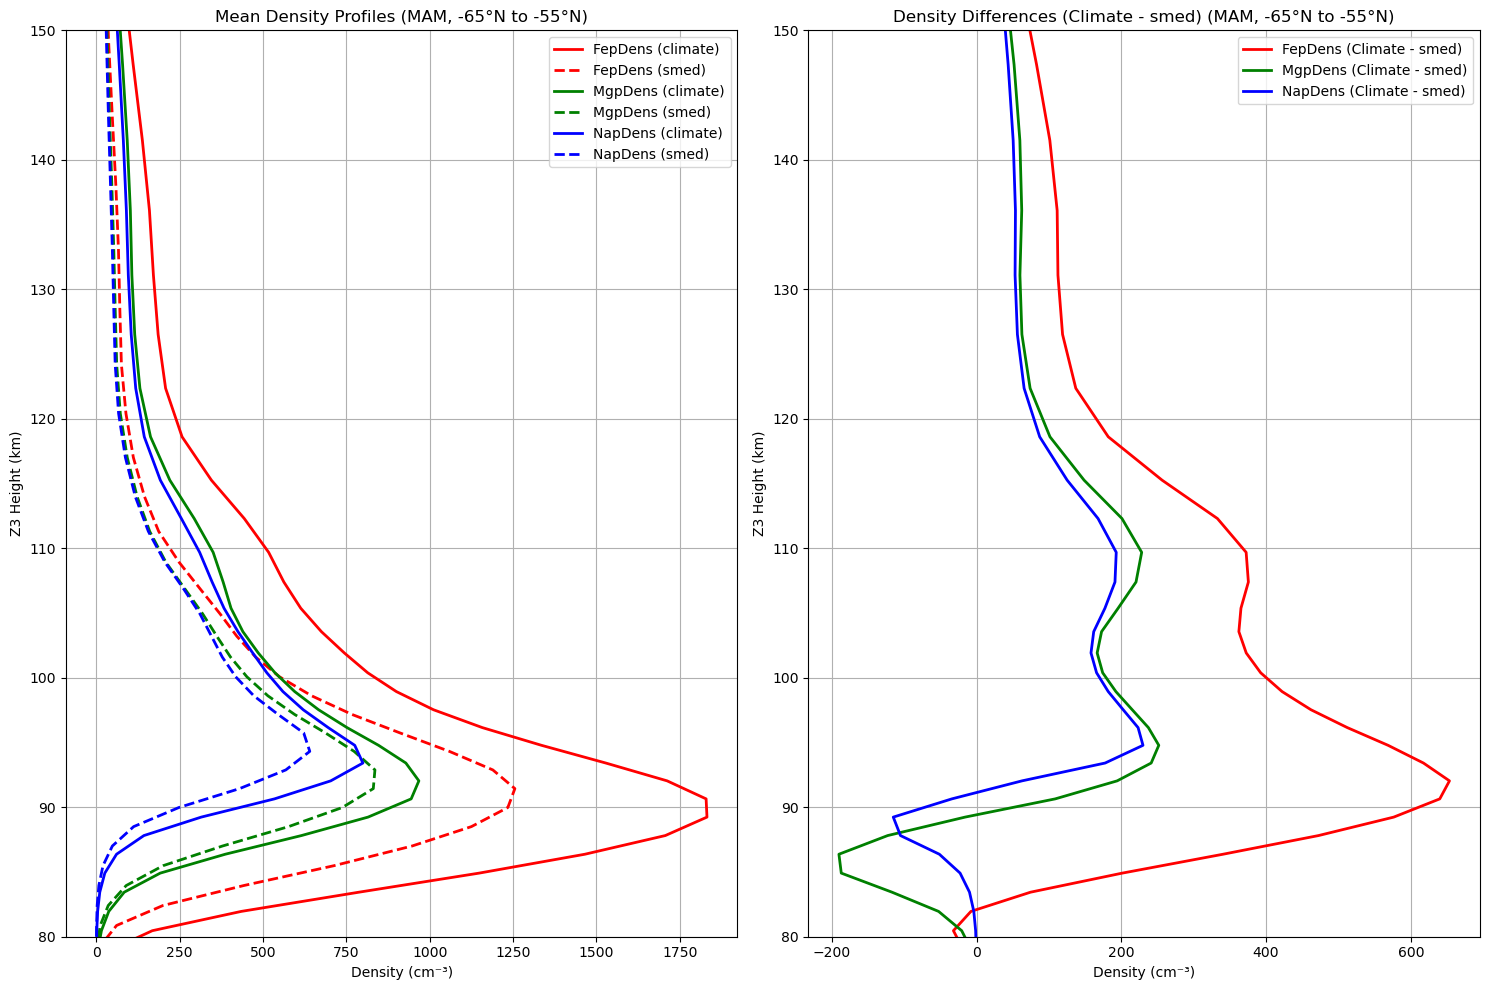

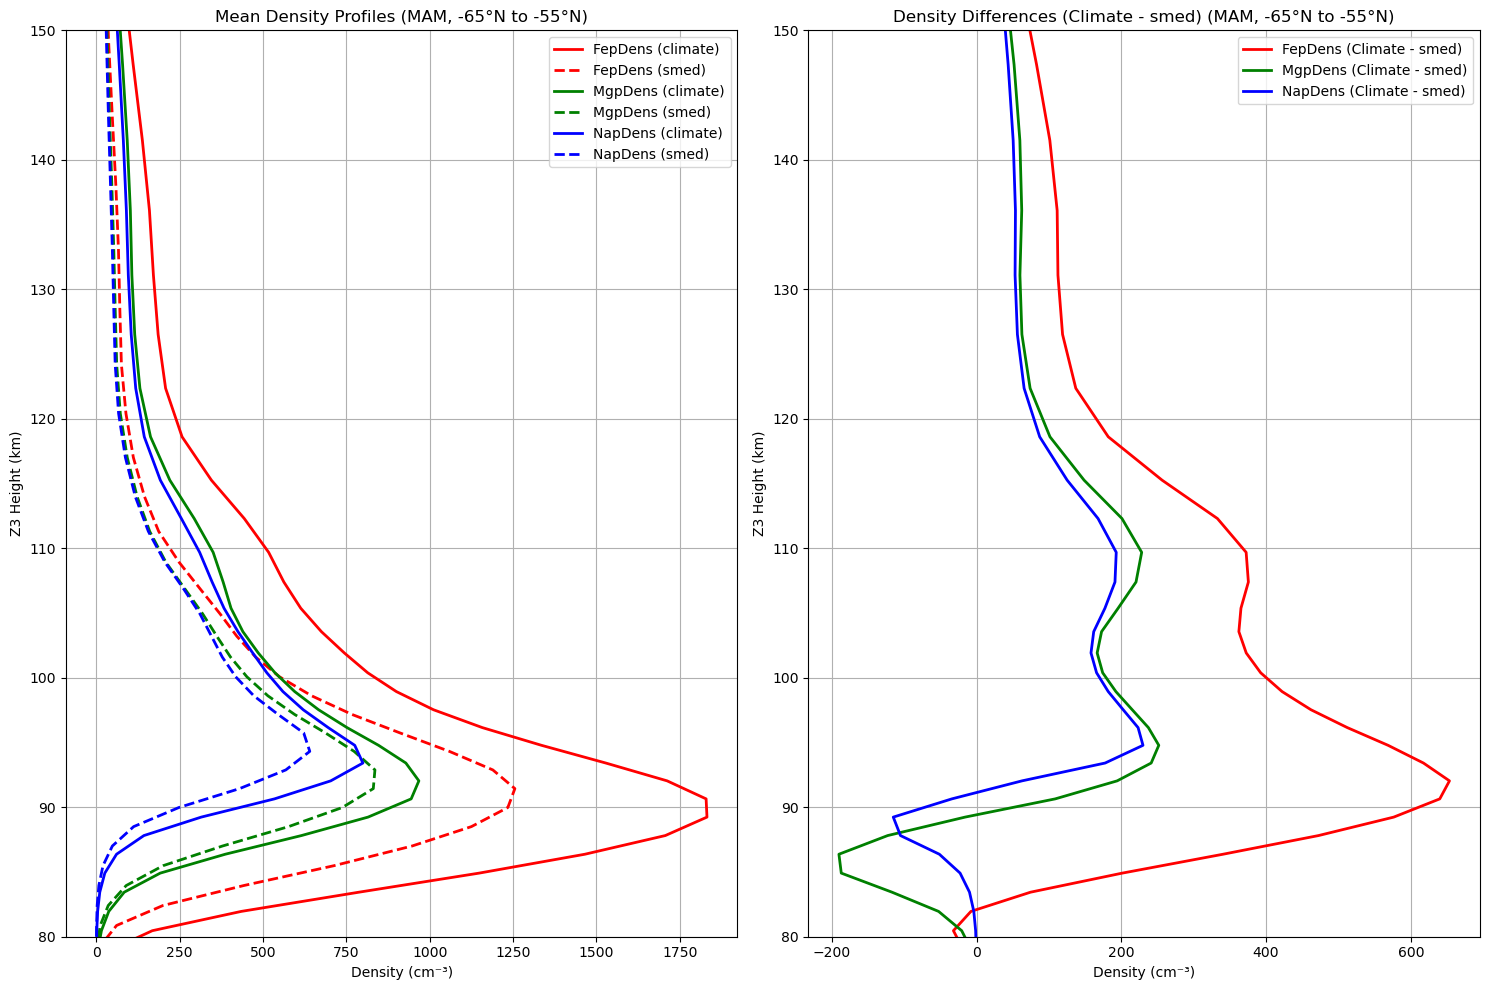

In [12]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ion_densities(climate_path, Smed_path)

In [9]:
def plot_height_profile_ion_densities(base_path_climate, climate_janfeb, base_path_smed):
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    data = {
        'climate': {'FepDens': [], 'MgpDens': [], 'NapDens': [], 'heights': []},
        'smed': {'FepDens': [], 'MgpDens': [], 'NapDens': [], 'heights': []}
    }

    target_months = ['12', '01', '02']

    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            # Use a different path for January and February in the climate scenario
            if scenario == 'climate' and month in ['01', '02']:
                file_pattern = climate_janfeb.format(month=month, day='*')
            else:
                file_pattern = base_path.format(month=month, day='*')

            files = glob.glob(file_pattern)

            if not files:
                print(f"No files found for {scenario} in month {month}.")
                continue

            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            # Apply latitude mask (-55 to -45)
            lat_mask = (ds.lat >= 15) & (ds.lat <= 25)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])

            for element in ['FepDens', 'MgpDens', 'NapDens']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var.mean(dim=['time', 'lat', 'lon'])
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)  # Convert to km

            ds.close()

    for scenario in data:
        for element in ['FepDens', 'MgpDens', 'NapDens']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    colors = {'FepDens': 'r', 'MgpDens': 'g', 'NapDens': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}

    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean,
                data[scenario]['mean_height'],
                color=color,
                linestyle=linestyle,
                linewidth=2,
                label=f'{element} ({scenario})'
            )

    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference,
            data['climate']['mean_height'],
            color=color,
            linewidth=2,
            label=f'{element} (Climate - smed)'
        )

    for ax, title in [(ax1, 'Mean Density Profiles (DJF, 15°N to 25°N)'),
                      (ax2, 'Density Differences (Climate - smed) (DJF, 15°N to 25°N)')]:
        ax.grid(True)
        ax.set_xlabel('Density (cm⁻³)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.set_ylim(80, 150)
        ax.legend()

    plt.tight_layout()
    return fig

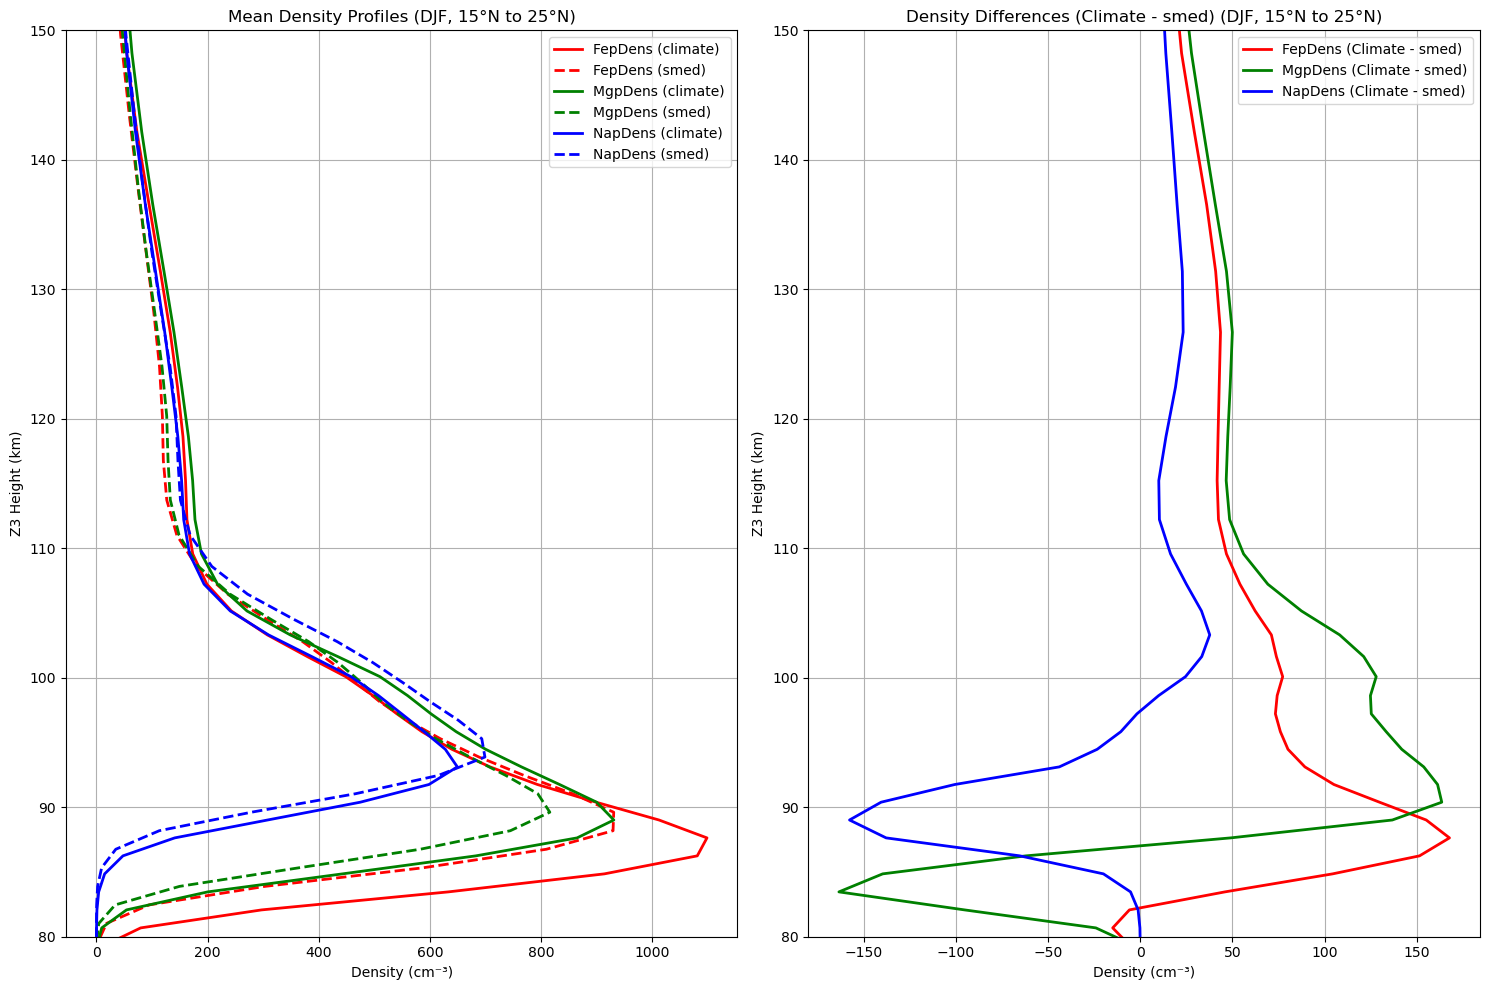

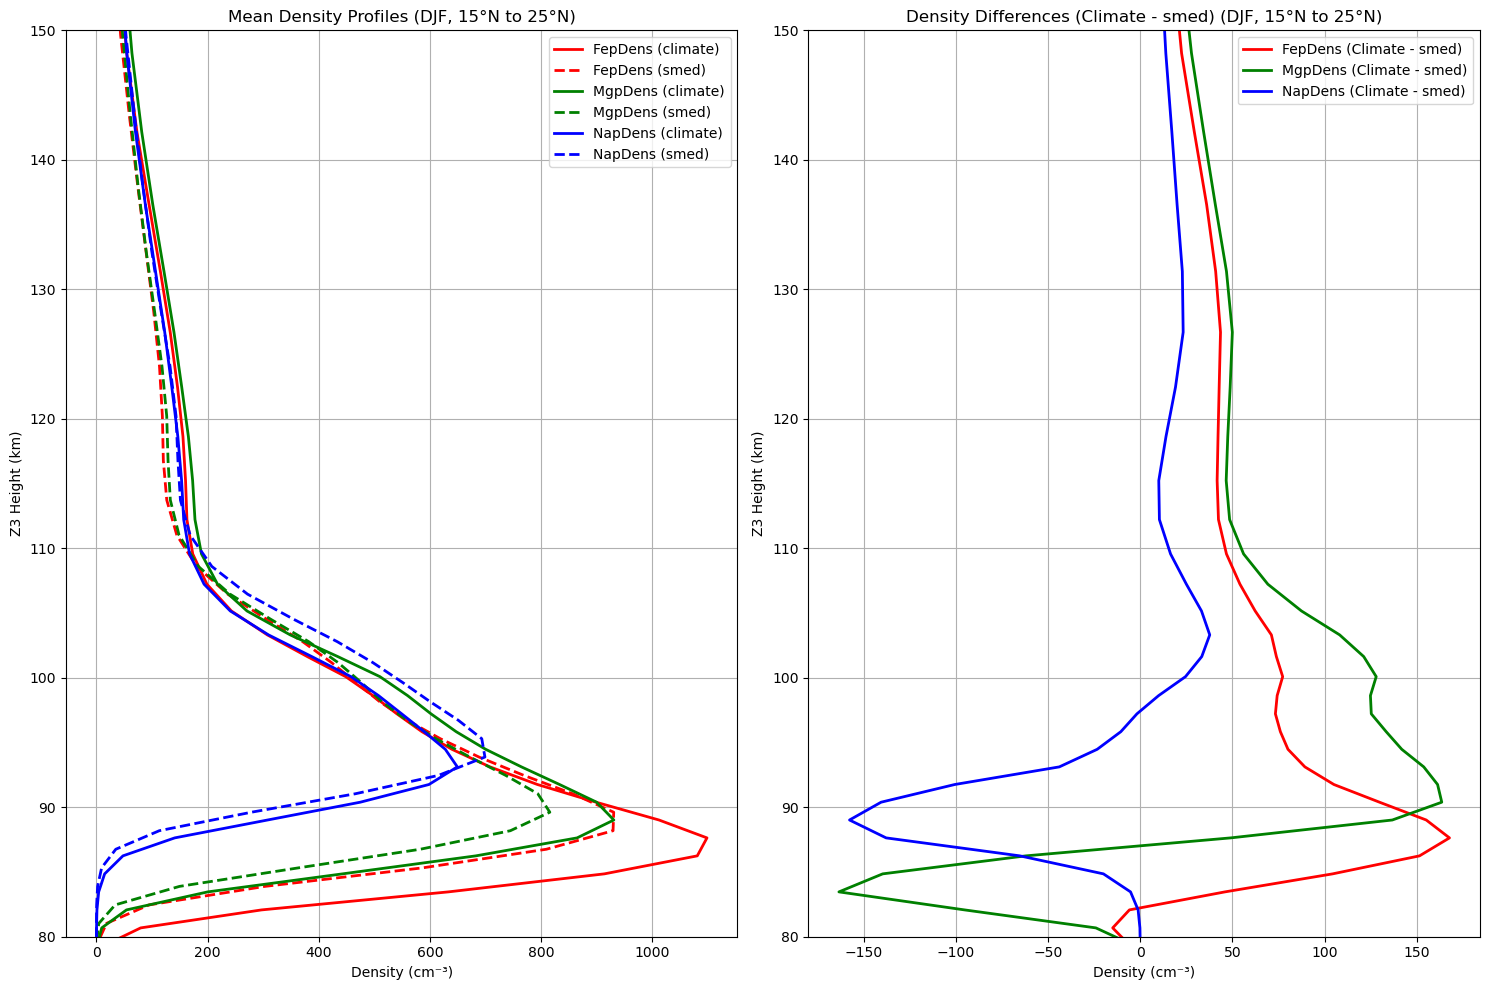

In [10]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
climate_janfeb = "/resstore/b0243/Data/Sporadic_E/FX2101f19f19mg16NaFeMgiontransport_OUTPUT/atm/hist/FX2101f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ion_densities(climate_path, climate_janfeb, Smed_path)

In [ ]:
def plot_height_profile_ion_densities(base_path_climate, climate_janfeb, base_path_smed):
    fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    data = {
        'climate': {'OpDens': [], 'MgpDens': [], 'NapDens': [], 'heights': []},
        'smed': {'FepDens': [], 'MgpDens': [], 'NapDens': [], 'heights': []}
    }

    target_months = ['12', '01', '02']

    for scenario, base_path in [('climate', base_path_climate), ('smed', base_path_smed)]:
        for month in target_months:
            # Use a different path for January and February in the climate scenario
            if scenario == 'climate' and month in ['01', '02']:
                file_pattern = climate_janfeb.format(month=month, day='*')
            else:
                file_pattern = base_path.format(month=month, day='*')

            files = glob.glob(file_pattern)

            if not files:
                print(f"No files found for {scenario} in month {month}.")
                continue

            ds = xr.open_mfdataset(files, combine='nested', concat_dim='time')

            # Apply latitude mask (-55 to -45)
            lat_mask = (ds.lat >= 15) & (ds.lat <= 25)
            ds_filtered = ds.sel(lat=ds.lat[lat_mask])

            for element in ['FepDens', 'MgpDens', 'NapDens']:
                element_profile = ds_filtered[element].mean(dim=['time', 'lat', 'lon'])
                data[scenario][element].append(element_profile.values)

            z3_var = ds_filtered.variables['Z3']
            h_geopotential = z3_var.mean(dim=['time', 'lat', 'lon'])
            data[scenario]['heights'].append(h_geopotential.values / 1000.0)  # Convert to km

            ds.close()

    for scenario in data:
        for element in ['FepDens', 'MgpDens', 'NapDens']:
            data[scenario][element] = np.array(data[scenario][element])
        data[scenario]['heights'] = np.array(data[scenario]['heights'])
        data[scenario]['mean_height'] = np.mean(data[scenario]['heights'], axis=0)

    colors = {'FepDens': 'r', 'MgpDens': 'g', 'NapDens': 'b'}
    line_styles = {'climate': '-', 'smed': '--'}

    for element, color in colors.items():
        for scenario, linestyle in line_styles.items():
            seasonal_mean = np.mean(data[scenario][element], axis=0)
            ax1.plot(
                seasonal_mean,
                data[scenario]['mean_height'],
                color=color,
                linestyle=linestyle,
                linewidth=2,
                label=f'{element} ({scenario})'
            )

    for element, color in colors.items():
        climate_mean = np.mean(data['climate'][element], axis=0)
        smed_mean = np.mean(data['smed'][element], axis=0)
        difference = climate_mean - smed_mean
        ax2.plot(
            difference,
            data['climate']['mean_height'],
            color=color,
            linewidth=2,
            label=f'{element} (Climate - smed)'
        )

    for ax, title in [(ax1, 'Mean Density Profiles (DJF, 15°N to 25°N)'),
                      (ax2, 'Density Differences (Climate - smed) (DJF, 15°N to 25°N)')]:
        ax.grid(True)
        ax.set_xlabel('Density (cm⁻³)')
        ax.set_ylabel('Z3 Height (km)')
        ax.set_title(title)
        ax.set_ylim(80, 150)
        ax.legend()

    plt.tight_layout()
    return fig

In [ ]:
climate_path = "/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
climate_janfeb = "/resstore/b0243/Data/Sporadic_E/FX2101f19f19mg16NaFeMgiontransport_OUTPUT/atm/hist/FX2101f19f19mg16NaFeMgiontransport.cam.h2.2100-{month}-{day}-*.nc"
Smed_path = "/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h2.0001-{month}-{day}-*.nc"
plot_height_profile_ion_densities(climate_path, climate_janfeb, Smed_path)